<a href="https://colab.research.google.com/github/nShravankg/PyTorch/blob/main/LSTM_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM,Dense,InputLayer
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv("/content/output.csv" )
scaler1= MinMaxScaler()

In [48]:
person = {}
  
for i in df['person_id'].tolist():
    per = df[df['person_id'] == i]
    person[i] = len(per)


csv_total = len(person)
values = sorted(list(person.values()))
print(values)


def getKeysByValue(dictOfElements, valueToFind):
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            person.pop(item[0])
            return item[0]

for i in values:
    key = getKeysByValue(person,i)
    person_req = df[df['person_id'] == key]
    print(f"df_{key}")
    globals()[f"df_{key}"] = person_req
    person_req.index.name='level_0'
    


[7, 9, 9, 10, 11, 16, 18, 19, 29, 29, 40, 40, 51, 53, 55, 57, 58, 61, 62, 67, 71, 78, 84, 84, 92, 105, 158, 192, 231, 237, 245, 258, 262]
df_40
df_6
df_33
df_15
df_72
df_18
df_69
df_39
df_47
df_64
df_25
df_38
df_21
df_27
df_53
df_11
df_44
df_58
df_61
df_49
df_68
df_13
df_8
df_42
df_28
df_16
df_4
df_31
df_3
df_5
df_10
df_2
df_1


In [63]:
df_1.tail()

,time,frame,person_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
level_0,,,,,,,,,,,,,,,,,,,,,
2740,2022-11-09 06:58:04.524303,254.0,1,0.0,0.0,0.0,0.0,0.0,0.0,169.15,...,183.08,384.18,166.74,413.90,183.27,412.36,168.11,445.61,179.09,438.65
2752,2022-11-09 06:58:24.137132,255.0,1,0.0,0.0,0.0,0.0,0.0,0.0,170.07,...,184.12,385.06,167.48,414.70,184.26,413.10,168.30,445.41,179.60,440.42
2762,2022-11-09 06:58:44.076032,256.0,1,0.0,0.0,0.0,0.0,0.0,0.0,169.59,...,184.29,384.82,167.40,414.69,184.31,414.13,168.48,445.03,180.88,443.25
2774,2022-11-09 06:59:02.870321,257.0,1,0.0,0.0,0.0,0.0,0.0,0.0,170.65,...,184.08,385.20,167.04,414.64,183.99,414.56,168.44,445.07,181.20,444.02
2788,2022-11-09 06:59:22.894220,258.0,1,0.0,0.0,0.0,0.0,0.0,0.0,171.27,...,183.67,385.49,167.17,414.41,184.08,414.37,168.34,444.24,181.99,443.37


In [49]:
person_work = df_1.drop(['time','person_id', 'frame'], axis=1)
person_focus  = person_work[['left_ankle_x','left_ankle_y','left_knee_x',	'left_knee_y','right_ankle_x', 'right_ankle_y',	'right_knee_x'	,'right_knee_y']]
person_focus_scaled = scaler1.fit_transform(person_focus)

In [ ]:
person_focus = person_focus.reset_index()
person_focus.drop(['level_0'],axis=1, inplace=True)
person_focus

In [52]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(person_focus)

seq_length = 10
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [53]:
x.shape


(251, 10, 8)

In [54]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [55]:
num_epochs = 2000
learning_rate = 0.01

input_size = 8
hidden_size = 2
num_layers = 3

num_classes = 8

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.99799
Epoch: 100, loss: 0.02670
Epoch: 200, loss: 0.02458
Epoch: 300, loss: 0.02220
Epoch: 400, loss: 0.01995
Epoch: 500, loss: 0.01773
Epoch: 600, loss: 0.01586
Epoch: 700, loss: 0.01430
Epoch: 800, loss: 0.01324
Epoch: 900, loss: 0.01247
Epoch: 1000, loss: 0.01184
Epoch: 1100, loss: 0.01135
Epoch: 1200, loss: 0.01099
Epoch: 1300, loss: 0.01071
Epoch: 1400, loss: 0.01050
Epoch: 1500, loss: 0.01031
Epoch: 1600, loss: 0.01015
Epoch: 1700, loss: 0.01000
Epoch: 1800, loss: 0.00986
Epoch: 1900, loss: 0.00973


In [57]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)




In [61]:
data_predict.shape

(251, 8)

In [60]:
len(dataY_plot[:,0])

251

In [98]:


frame_nums_pred = [i for i in range(251,263)]
len(frame_nums_pred)
frame_nums_act = [i for i in range(250,262)]
len(frame_nums_act)

12

In [68]:
person_focus.tail(12).index

RangeIndex(start=250, stop=262, step=1)

In [84]:
len(data_predict[:,0][-12:])

12

In [100]:
pred_df = pd.DataFrame({'frame':frame_nums_pred,'pred_values_left_knee_x':data_predict[:,0][-12:]})
pred_df.set_index(['frame'], inplace=True)
pred_df

,pred_values_left_knee_x
frame,
251,157.791687
252,157.586090
253,157.180634
254,157.438034
255,156.794907
256,156.080704
257,155.769745
258,156.337723
259,156.121857


In [106]:
person_focus['left_ankle_x'].tail(12)

250    168.46
251    168.69
252    167.96
253    167.85
254    167.55
255    167.82
256    167.98
257    168.11
258    168.30
259    168.48
260    168.44
261    168.34
Name: left_ankle_x, dtype: float64

Text(0.5, 1.0, 'Left_Knee_X')

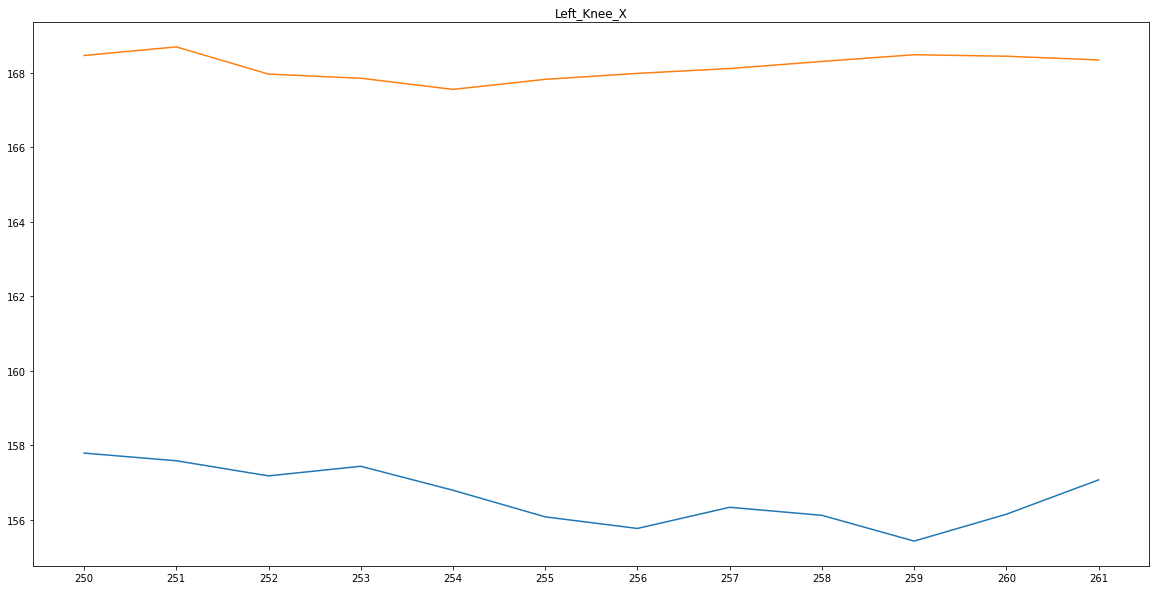

In [108]:
frame = person_focus.tail(12).index
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
n_f = pred_df
p_d = person_focus['left_ankle_x'].tail(12)
plt.xticks(np.arange(250, 263, 1))
plt.plot(frame,n_f, p_d)
plt.title('Left_Knee_X')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'p' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/lo

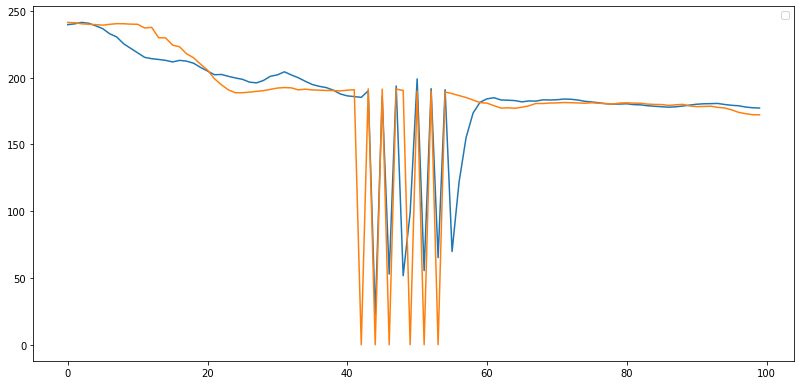

In [65]:
# plt.axvline(x=train_size, c='r', linestyle='--')
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(30)
frame = person_focus.index[:100]
laxp = data_predict[:,0][:100]
laxa = dataY_plot[:,0][:100]
plt.subplot(4, 2, 1)  
plt.plot(frame,laxp,laxa)
plt.legend("prediction", "actuals")
# plt.title('Left_Ankle_X')
# plt.plot(data_predict[:,0])
# plt.plot(dataY_plot[:,0])
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [41]:
data_predict[:,0][:10]

array([242.21655, 241.5835 , 237.26416, 235.50198, 233.03146, 230.37726,
       229.31827, 224.407  , 224.65775, 221.10506], dtype=float32)

In [35]:
person_focus.index[:261]

Int64Index([   0,   11,   21,   30,   40,   47,   55,   64,   71,   80,
            ...
            2667, 2682, 2695, 2706, 2716, 2727, 2740, 2752, 2762, 2774],
           dtype='int64', name='level_0', length=261)